# 7.3.1. NiN Blocks

Recall that the inputs and outputs of convolutional layers consist of four-dimensional tensors with axes corresponding to the example, channel, height, and width. Also recall that the inputs and outputs of fully-connected layers are typically two-dimensional tensors corresponding to the example and feature. The idea behind NiN is to apply a fully-connected layer at each pixel location (for each height and width). If we tie the weights across each spatial location, we could think of this as a  1×1  convolutional layer (as described in Section 6.4) or as a fully-connected layer acting independently on each pixel location. Another way to view this is to think of each element in the spatial dimension (height and width) as equivalent to an example and a channel as equivalent to a feature.

Fig. 7.3.1 illustrates the main structural differences between VGG and NiN, and their blocks. The NiN block consists of one convolutional layer followed by two  1×1  convolutional layers that act as per-pixel fully-connected layers with ReLU activations. The convolution window shape of the first layer is typically set by the user. The subsequent window shapes are fixed to  1×1 .

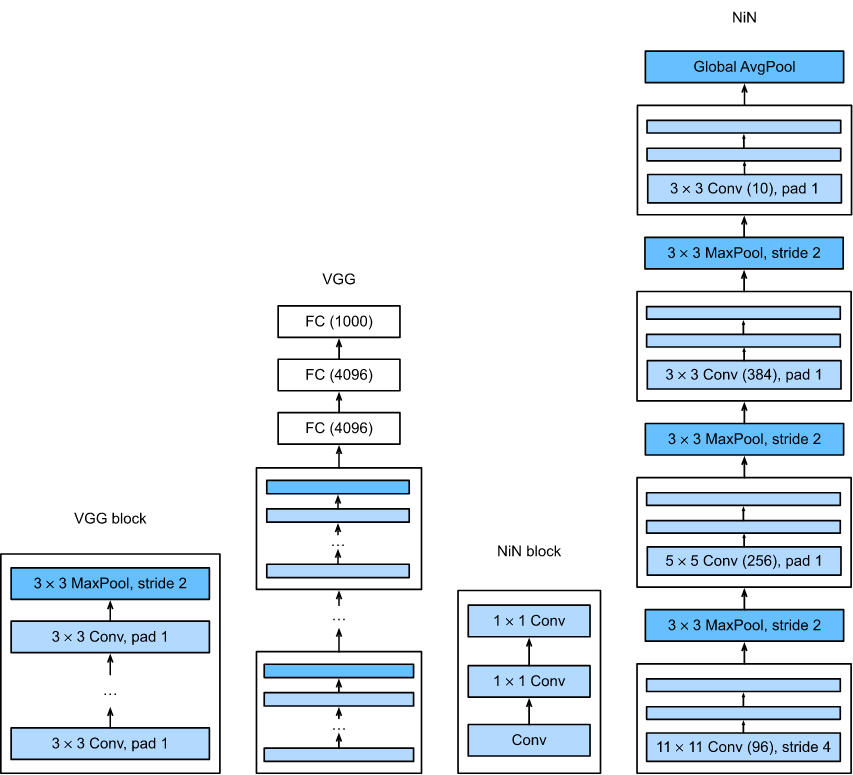

In [18]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(), nn.Conv2d(out_channels, out_channels, kernel_size=1))

# 7.3.2. NiN Model

The original NiN network was proposed shortly after AlexNet and clearly draws some inspiration. NiN uses convolutional layers with window shapes of  11×11 ,  5×5 , and  3×3 , and the corresponding numbers of output channels are the same as in AlexNet. Each NiN block is followed by a maximum pooling layer with a stride of 2 and a window shape of  3×3 .

One significant difference between NiN and AlexNet is that NiN avoids fully-connected layers altogether. Instead, NiN uses an NiN block with a number of output channels equal to the number of label classes, followed by a global average pooling layer, yielding a vector of logits. One advantage of NiN’s design is that it significantly reduces the number of required model parameters. However, in practice, this design sometimes requires increased model training time.


In [19]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nin_block(384, 10, kernel_size=3, padding=1, strides=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten())


In [20]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 24, 24])
MaxPool2d output shape:	 torch.Size([1, 256, 11, 11])
Sequential output shape:	 torch.Size([1, 384, 11, 11])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])


/Users/seyeon/Desktop/d2i_pytorch/d2i_env/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


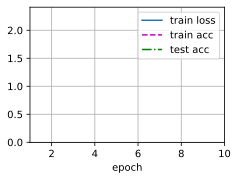

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())